# Using ML to create a playlist with friends

The ultimate goal of this project was to use personal playlist data of three friends/classmates to create a playlist of songs all of us will enjoy based on past listening habits.

Based off articles written by others, we decided to use supervised machine learning techniques to do this. In order to do this, we each have 100 songs marked as 'like' and 40 songs marked as 'dislike' as our training data. Due to the timing of this project (December 2019), we decided to take our "Top Songs of 2019" playlist as our liked songs. Creating a playlist of 100 songs we 'dislike' was a much harder task. In order to assure each of our disliked songs weren't biased towards musical features of one genre, we each went to at least 5 different genre playlists -- including genres we like -- and picked 40 songs we dislike. We understand that this introduces bias into the model, but decided it was the best way to go about creating the model, and is sufficient for the purposes of this project. 

We will then use the built model to predict whether each individual will like or dislike songs from Spotify's "Top Tracks of 2017: USA" playlist, then take any songs all 3 of us will like and put them into one playlist. The 2017 playlist was chosen in hopes that this would reduce the chances of a song being on this playlist as well as our own Top Songs of 2019 playlists. 


## Get personal playlist data

The first step was for each of us to get our personal playlist data. Since we are getting data at the user level, we each had to do this separately with our own Client ID and Client Secret, then merge the data together. 

Each person ran the code below on their own to get their personal data, then we will combine our data together and do some EDA.

### Example code to scrape an individual's data

In [27]:
# Install spotipy package
!pip install spotipy
!pip install xlsxwriter


In [28]:
# Import necessary packages
import spotipy as sp
import pandas as pd
from spotipy.oauth2 import SpotifyClientCredentials #To access authorised Spotify data
from spotipy import util
import json
from pandas.io.json import json_normalize
from pandas import ExcelWriter
import xlsxwriter
import numpy as np


In [29]:
# Create Client ID and Client Secret on http://developer.spotify.com
client_id='paste_client_id_here'
client_secret='paste_client_secret_here'

# Change name to your name and username to your Spotify username
name='your_first_name'
username='your_spotify_username'
scope='playlist-read-private playlist-read-collaborative user-read-recently-played ' + \
'user-follow-read user-read-currently-playing user-library-read user-top-read'

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
# Spotify object to access API
sp1 = sp.Spotify(client_credentials_manager=client_credentials_manager)
# This will prompt you to accept the terms, then copy the link of the page it redirects
# you to and paste that link in the input box that pops up and hit enter
# You WILL get an error, that is correct, copy and paste the link still
token = util.prompt_for_user_token(username,scope,client_id=client_id,client_secret=client_secret,redirect_uri='http://localhost/')
sp2 = sp.Spotify(auth=token)

In [30]:
sp2.current_user()

{'display_name': 'pdriever',
 'external_urls': {'spotify': 'https://open.spotify.com/user/pdriever'},
 'followers': {'href': None, 'total': 1},
 'href': 'https://api.spotify.com/v1/users/pdriever',
 'id': 'pdriever',
 'images': [],
 'type': 'user',
 'uri': 'spotify:user:pdriever'}

In [31]:
# Get your Top 2019 playlist and USA Top Tracks of 2017
# NOTE: you need to have these playlists favorited or followed
result4 = sp2.user_playlists(username)
user_playlists = pd.DataFrame(json_normalize(result4['items']))
top2019 = user_playlists[(user_playlists['name'] == 'Your Top Songs 2019') ]
top2017usa = user_playlists[(user_playlists['name']=='Top Tracks of 2017: USA')]
dislike = user_playlists[(user_playlists['name'] == 'dislike') ] 
#'dislike' is what we each titled our dislike playlists; enter title of yours if different

In [32]:
# Get all of the track info for each track in the 2019 playlist
top2019_songs = json_normalize(sp2.user_playlist_tracks(username, playlist_id=top2019['id'].tolist()[0], fields=None, 
                                                        limit=100, offset=0, market=None)['items'])
audio2019 = pd.DataFrame(json_normalize(sp2.audio_features(tracks=top2019_songs['track.uri'].tolist())))
songs_with_audio2019 = top2019_songs.merge(audio2019,how='left',left_on='track.uri',right_on='uri')

# Same as previous cell just with 2017 playlist
top2017_songs = json_normalize(sp2.user_playlist_tracks(username, playlist_id=top2017usa['id'].tolist()[0], fields=None, 
                                                        limit=100, offset=0, market=None)['items'])
audio_top2017 = pd.DataFrame(json_normalize(sp2.audio_features(tracks=top2017_songs['track.uri'].tolist())))
songs_with_audio_top2017 = top2017_songs.merge(audio_top2017,how='left',left_on='track.uri',right_on='uri')

# Same as previous cell just with dislike playlist
dislike_songs = json_normalize(sp2.user_playlist_tracks(username, playlist_id=dislike['id'].tolist()[0], fields=None, 
                                                        limit=100, offset=0, market=None)['items'])
audio_dislike = pd.DataFrame(json_normalize(sp2.audio_features(tracks=dislike_songs['track.uri'].tolist())))
songs_with_audio_dislike = dislike_songs.merge(audio_dislike,how='left',left_on='track.uri',right_on='uri')

In [33]:
# Get artist information for the 2019 playlist
artists2019 = []
for item in (top2019_songs['track.album.artists'].tolist()):
    df = pd.DataFrame(json_normalize(item[0]))
    artists2019.append(df['uri'][0])
 

artist2019_info = pd.DataFrame(json_normalize(sp2.artists(artists2019[0:50])['artists']))
new = pd.DataFrame(json_normalize(sp2.artists(artists2019[50:])['artists']))
final_artists2019 = artist2019_info.append(new)

# Get artist info for 2017 playlist
artists_top2017= []
for item in top2017_songs['track.album.artists'].tolist():
    df = pd.DataFrame(json_normalize(item[0]))
    artists_top2017.append(df['uri'][0])
    
artist_top2017_info = pd.DataFrame(json_normalize(sp2.artists(artists_top2017[0:50])['artists']))
new = pd.DataFrame(json_normalize(sp2.artists(artists_top2017[50:])['artists']))
final_artists_top2017 = artist_top2017_info.append(new)

# Get artist info for dislike playlist
artists_dislike= []
for item in dislike_songs['track.album.artists'].tolist():
    df = pd.DataFrame(json_normalize(item[0]))
    artists_dislike.append(df['uri'][0])
    
artist_dislike_info = pd.DataFrame(json_normalize(sp2.artists(artists_dislike[0:50])['artists']))
#new = pd.DataFrame(json_normalize(sp2.artists(artists_dislike[50:])['artists']))
# NOTE: if your dislike playlist is > 50 songs, uncomment the above line and .append below
final_artists_dislike = artist_dislike_info#.append(new)

In [34]:
# Add a column with your name so that we can merge our data
songs_with_audio2019['username'] = name
songs_with_audio_top2017['username'] = name
songs_with_audio_dislike['username'] = name
final_artists2019['username'] = name
final_artists_top2017['username'] = name
final_artists_dislike['username'] = name

# Add column indicating which playlist the track was from - Top 2019, Top 2017, or dislike
songs_with_audio2019['playlist'] = 'top_2019'
songs_with_audio_top2017['playlist'] = 'top_2017'
songs_with_audio_dislike['playlist'] = 'dislike'
final_artists2019['playlist'] = 'top_2019'
final_artists_top2017['playlist'] = 'top_2017'
final_artists_dislike['playlist'] = 'dislike'

In [35]:
# Concatenate information for 2019, 2017, & dislike playlists into song dataframe & artist dataframe
all_songs = songs_with_audio2019.append(songs_with_audio_dislike)
all_songs = all_songs.append(songs_with_audio_top2017)
all_artists = final_artists2019.append(final_artists_dislike)
all_artists = all_artists.append(final_artists_top2017)

In [36]:
# Save file to this source file location
writer = pd.ExcelWriter('yourname_spotify.xlsx', engine='xlsxwriter')
all_songs.to_excel(writer,sheet_name='songs')
all_artists.to_excel(writer,sheet_name='artists')
writer.save()

After each person runs the above code, you have scraped all the necessary data. Now for some fun EDA. 

# Exploratory Data Analysis

Now that we each have our individual data, we can merge our files and do some exploratory data analysis before creating the models. Make sure your data and each of your friends' data is saved in the source location of this file. 

**From now on, everywhere you see 'yourname' replace with your name.
Everywhere you see 'name2' replace with name of second person.
Everywhere you see 'name3' replace with name of third person.**

In [37]:
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn import svm

In [38]:
# Get only meaningful data for songs and artists
yourname_songs = pd.read_excel('yourname_spotify.xlsx', sheet_name='songs')
yourname_songs = yourname_songs[['track.album.name','track.album.release_date','track.artists','track.explicit','track.id','track.name','track.popularity','track.uri','acousticness','danceability','duration_ms','energy','id','instrumentalness','key','liveness','loudness','mode','speechiness','tempo','time_signature','uri','valence','username','playlist']]
name2_songs = pd.read_excel('name2_spotify.xlsx', sheet_name='songs')
name2_songs = name2_songs[['track.album.name','track.album.release_date','track.artists','track.explicit','track.id','track.name','track.popularity','track.uri','acousticness','danceability','duration_ms','energy','id','instrumentalness','key','liveness','loudness','mode','speechiness','tempo','time_signature','uri','valence','username','playlist']]
name3_songs = pd.read_excel('name3_spotify.xlsx', sheet_name='songs')
name3_songs = name3_songs[['track.album.name','track.album.release_date','track.artists','track.explicit','track.id','track.name','track.popularity','track.uri','acousticness','danceability','duration_ms','energy','id','instrumentalness','key','liveness','loudness','mode','speechiness','tempo','time_signature','uri','valence','username','playlist']]

yourname_artists = pd.read_excel('yourname_spotify.xlsx', sheet_name='artists')
yourname_artists = yourname_artists[['followers.total','genres','id','name','popularity','uri','username','playlist']]
name2_artists = pd.read_excel('name2_spotify.xlsx', sheet_name='artists')
name2_artists = name2_artists[['followers.total','genres','id','name','popularity','uri','username','playlist']]
name3_artists = pd.read_excel('name3_spotify.xlsx', sheet_name='artists')
name3_artists = name3_artists[['followers.total','genres','id','name','popularity','uri','username','playlist']]


In [ ]:
# Get dataframes of only songs from top 2019 playlist -- so songs you each like
yourname_likes = yourname_songs[yourname_songs.playlist == 'top_2019']
name2_likes = name2_songs[yourname_songs.playlist == 'top_2019']
name3_likes = name3_songs[yourname_songs.playlist == 'top_2019']

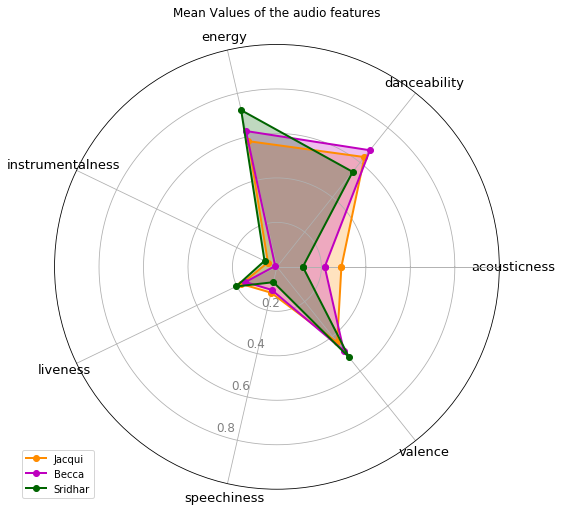

In [39]:
# Create radial chart showing individual averages of select song features
yourname_features = yourname_likes[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence']]
name2_features = name2_likes[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence']]
name3_features = name3_likes[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence']]

labels= list(yourname_features)[:]
stats= yourname_features.mean().tolist()
stats2 = name2_features.mean().tolist()
stats3 = name3_features.mean().tolist()

angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)

# close the plot
stats=np.concatenate((stats,[stats[0]]))
stats2 =np.concatenate((stats2,[stats2[0]])) 
stats3 = np.concatenate((stats3,[stats3[0]])) 
angles=np.concatenate((angles,[angles[0]]))

#Size of the figure
fig=plt.figure(figsize = (18,18))

ax = fig.add_subplot(221, polar=True)
ax.plot(angles, stats, 'o-', linewidth=2, label = "yourname", color= 'darkorange')
ax.fill(angles, stats, alpha=0.25, facecolor='darkorange')
ax.set_thetagrids(angles * 180/np.pi, labels , fontsize = 13)


ax.set_rlabel_position(250)
plt.yticks([0.2 , 0.4 , 0.6 , 0.8  ], ["0.2",'0.4', "0.6", "0.8"], color="grey", size=12)
plt.ylim(0,1)

ax.plot(angles, stats2, 'o-', linewidth=2, label = "name2", color = 'm')
ax.fill(angles, stats2, alpha=0.25, facecolor='m' )
ax.set_title('Mean Values of the audio features')
ax.grid(True)

ax.plot(angles, stats3, 'o-', linewidth=2, label = "name3", color= 'darkgreen')
ax.fill(angles, stats3, alpha=0.25, facecolor='darkgreen')

plt.legend(loc='best', bbox_to_anchor=(0.1, 0.1))



# **Model Building**

The next step is to build a model for each individual that will predict whether or not we will like a song based on certain features. 

Each person should go back to their individual notebook where they scraped their data, and run this "Model Building" section. 

In [41]:
# Install and import necessary packages
!pip install featuretools
from sklearn.preprocessing import LabelEncoder
import featuretools as ft
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score 
from sklearn.linear_model import LogisticRegression

# Individual Predictions

PLEASE note that this assignment was used for a data visualization class in our first quarter as MSBA students. We have not yet taken machine learning, so these models are extremely basic and taken from simple Kaggle models found. We have not done any feature engineering or techniques to make the best model possible. For the purposes of this assignment, we wanted a model that would perform decently. Perhaps in the coming quarters, as we dive into ML and advanced statistics, we will update and improve these models. 

## **Logistic Regression**

First, we will try a logistic regression to see if we can determine whether or not an individual likes a song based on probabilities.

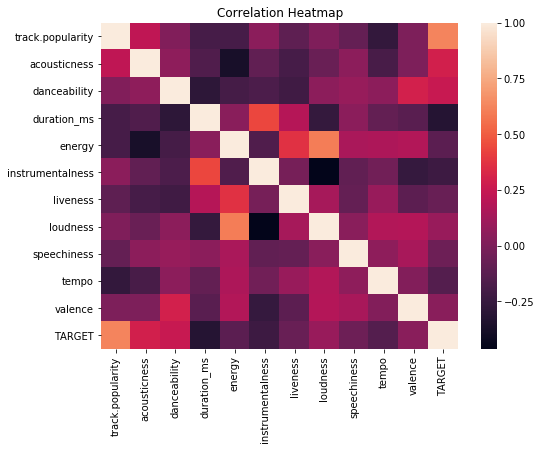

In [42]:
# We need to create a binary like/dislike column. 
# We will make 1 = like and 0 = dislike.
yourname_songs.loc[yourname_songs['playlist']=='top_2019', 'like'] = 1
yourname_songs.loc[yourname_songs['playlist']=='dislike', 'like'] = 0

# Since 'yourname' data contains the 2017 playlist as well, we want to exclude that from 
# training. So, we only take songs that we have given a 'like' value to
data = yourname_songs.loc[yourname_songs['like'] >= 0]
# We want to train the data on a random sample of 70 songs (half), but in order to ensure the 
# proportion of like/dislike is okay, we set the weights proportional to the 'like' column
train = data.sample(n=70, replace=False,weights=data.groupby('like')['like'].transform('count'))
# The testing data is the remaining 70 songs that are not in the train set
test = data[~data.isin(train)].dropna()

# The training set target 0/1 is defined by the 'like' column
train['TARGET'] = train['like']
# For now, we set the testing target as null
test['TARGET'] = np.nan

# Just to see the proportion of likes & dislikes the random sample included
train['TARGET'].value_counts()
# Checking what the actual number of likes & dislikes are in the test data
test['like'].value_counts()

# Define features to train and test the model on
train_model = train[['track.popularity','acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence','TARGET']]
test_model = test[['track.popularity','acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence']]

# Find correlations with the target and sort
# Another basic EDA
correlations = train_model.corr()['TARGET'].sort_values()
correlations

corr_features = train_model.corr()
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(corr_features)
plt.title('Correlation Heatmap');

In [43]:
# Label the training likes and dislikes from the TARGET column defined earlier
train_labels = train_model['TARGET']

# Drop the target from the training data
if 'TARGET' in train_model:
    train = train_model.drop(columns = ['TARGET'])
else:
    train = train_model.copy()

# Get a list of feature names
features = list(train.columns)

# Train the model
log_reg = LogisticRegression()
log_reg.fit(train, train_labels)

# Make predictions
log_reg_pred = log_reg.predict(test_model)
# Label whether a tested song was actually liked or disliked
test_labels = test['like']

# See how accurate the regression was at 
# predicting whether or not a song was liked or disliked
log_score = accuracy_score(log_reg_pred, test_labels)
print(log_score)

0.6571428571428571


## **Random Forest**

We can try non-parametric models such as decision tree models to attempt to better predict which songs we will like.

In [47]:
from sklearn.ensemble import RandomForestClassifier

In [48]:
random_forest = RandomForestClassifier()

# Train on the training data
random_forest.fit(train, train_labels)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
rf_predictions = random_forest.predict(test_model)

rf_score = accuracy_score(rf_predictions, test_labels)
print(rf_score)

0.6714285714285714


In [49]:
def plot_feature_importances(df):
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

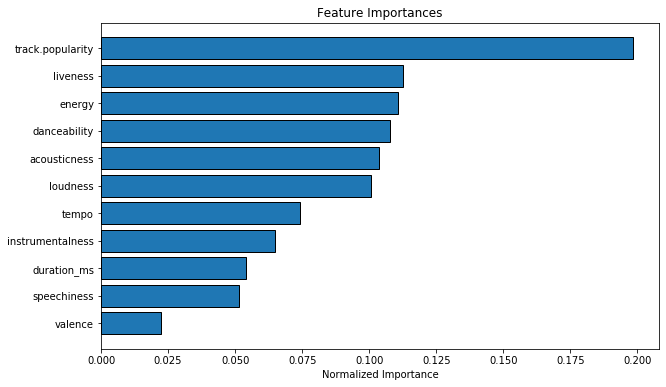

In [50]:
# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

# Using entire training data and 2017 playlist as test

Now that we have seen the accuracy of the two models, we can follow the same steps as above using the entire like & dislike playlists as the training data and the unknowns of the 2017 playlist as the test data. We all found that the Random Forest model was best, so we'll use that model for this part. 

In [51]:
yourname_songs.loc[yourname_songs['playlist']=='top_2019', 'like'] = 1
yourname_songs.loc[yourname_songs['playlist']=='dislike', 'like'] = 0

train = yourname_songs.loc[yourname_songs['like'] >= 0]
test = yourname_songs[yourname_songs.playlist == 'top_2017']

train['TARGET'] = train['like']
test['TARGET'] = np.nan

train['TARGET'].value_counts()

train_model = train[['track.popularity','acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence','TARGET']]
test_model = test[['track.popularity','acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence']]

train_labels = train_model['TARGET']

if 'TARGET' in train_model:
    train = train_model.drop(columns = ['TARGET'])
else:
    train = train_model.copy()

features = list(train.columns)

## **Random Forest**

In [53]:
# Train on the training data
random_forest.fit(train, train_labels)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
rf_predictions = random_forest.predict(test_model)

rf_predictions = rf_predictions.tolist()

test['TARGET'] = rf_predictions

yourname_test = test

test['TARGET'].sum()

76.0

In [54]:
yourname_test.to_csv('yourname_predictions.csv')

In [57]:
yourname_test

,track.album.name,track.album.release_date,track.artists,track.explicit,track.id,track.name,track.popularity,track.uri,acousticness,danceability,...,mode,speechiness,tempo,time_signature,uri,valence,username,playlist,like,TARGET
240,DAMN.,2017-04-14,[{'external_urls': {'spotify': 'https://open.s...,True,7KXjTSCq5nL1LoYtL7XAwS,HUMBLE.,85,spotify:track:7KXjTSCq5nL1LoYtL7XAwS,0.000282,0.908,...,0,0.1020,150.011,4,spotify:track:7KXjTSCq5nL1LoYtL7XAwS,0.4210,Becca,top_2017,NaN,0.0
241,Luv Is Rage 2,2017-08-25,[{'external_urls': {'spotify': 'https://open.s...,True,7GX5flRQZVHRAGd6B4TmDO,XO Tour Llif3,85,spotify:track:7GX5flRQZVHRAGd6B4TmDO,0.002640,0.732,...,0,0.2310,155.096,4,spotify:track:7GX5flRQZVHRAGd6B4TmDO,0.4010,Becca,top_2017,NaN,0.0
242,÷ (Deluxe),2017-03-03,[{'external_urls': {'spotify': 'https://open.s...,False,7qiZfU4dY1lWllzX7mPBI3,Shape of You,87,spotify:track:7qiZfU4dY1lWllzX7mPBI3,0.581000,0.825,...,0,0.0802,95.977,4,spotify:track:7qiZfU4dY1lWllzX7mPBI3,0.9310,Becca,top_2017,NaN,1.0
243,Stoney (Deluxe),2016-12-09,[{'external_urls': {'spotify': 'https://open.s...,True,3a1lNhkSLSkpJE4MSHpDu9,Congratulations,85,spotify:track:3a1lNhkSLSkpJE4MSHpDu9,0.215000,0.630,...,1,0.0363,123.146,4,spotify:track:3a1lNhkSLSkpJE4MSHpDu9,0.4920,Becca,top_2017,NaN,1.0
244,Despacito Feat. Justin Bieber (Remix),2017-04-17,[{'external_urls': {'spotify': 'https://open.s...,False,5CtI0qwDJkDQGwXD1H1cLb,Despacito - Remix,25,spotify:track:5CtI0qwDJkDQGwXD1H1cLb,0.229000,0.694,...,1,0.1200,88.931,4,spotify:track:5CtI0qwDJkDQGwXD1H1cLb,0.8130,Becca,top_2017,NaN,1.0
245,FUTURE,2017-06-30,[{'external_urls': {'spotify': 'https://open.s...,True,0VgkVdmE4gld66l8iyGjgx,Mask Off,81,spotify:track:0VgkVdmE4gld66l8iyGjgx,0.010200,0.833,...,1,0.4310,150.062,4,spotify:track:0VgkVdmE4gld66l8iyGjgx,0.2810,Becca,top_2017,NaN,1.0
246,iSpy (feat. Lil Yachty),2016-12-02,[{'external_urls': {'spotify': 'https://open.s...,True,2EEeOnHehOozLq4aS0n6SL,iSpy (feat. Lil Yachty),78,spotify:track:2EEeOnHehOozLq4aS0n6SL,0.378000,0.746,...,1,0.2890,75.016,4,spotify:track:2EEeOnHehOozLq4aS0n6SL,0.6720,Becca,top_2017,NaN,1.0
247,American Teen,2017-04-27,[{'external_urls': {'spotify': 'https://open.s...,False,152lZdxL1OR0ZMW6KquMif,Location,83,spotify:track:152lZdxL1OR0ZMW6KquMif,0.330000,0.736,...,0,0.4250,80.126,4,spotify:track:152lZdxL1OR0ZMW6KquMif,0.3260,Becca,top_2017,NaN,1.0
248,24K Magic,2016-11-17,[{'external_urls': {'spotify': 'https://open.s...,False,0KKkJNfGyhkQ5aFogxQAPU,That's What I Like,83,spotify:track:0KKkJNfGyhkQ5aFogxQAPU,0.013000,0.853,...,1,0.0406,134.066,4,spotify:track:0KKkJNfGyhkQ5aFogxQAPU,0.8600,Becca,top_2017,NaN,1.0
249,Jungle Rules,2017-07-14,[{'external_urls': {'spotify': 'https://open.s...,True,3B54sVLJ402zGa6Xm4YGNe,Unforgettable,83,spotify:track:3B54sVLJ402zGa6Xm4YGNe,0.029300,0.726,...,1,0.1230,97.985,4,spotify:track:3B54sVLJ402zGa6Xm4YGNe,0.7330,Becca,top_2017,NaN,1.0


# Combine all predictions

After each person has run the model above to get the predictions of which songs from the 2017 playlist they are predicted to like, we can merge all of the data to build the final playlist.

Again, make sure their data is stored in the same source location as this notebook.

In [55]:
# Import friends' data
name2_test = pd.read_csv('name2_predictions.csv')
name3_test = pd.read_csv('name3_predictions.csv')

In [60]:
# Just take the column that identifies each songs and TARGET column 
# from friends' files to merge into one file
name2_likes = name2_test[['track.uri','TARGET']]
name3_likes = name3_test[['track.uri','TARGET']]
all_predictions = yourname_test.merge(name2_likes, how = 'inner', on = 'track.uri')
all_predictions = all_predictions.merge(name3_likes, how = 'inner', on = 'track.uri')


In [67]:
all_predictions.to_csv('all_predictions.csv')

In the above file, TARGET_x shows whether or not you are predicted to like a song.
TARGET_y shows whether or not name2 is predicted to like a song.
And TARGET shows whether or not name3 is predicted to like a song.

In [63]:
# a = songs you like
# b = songs you like and name2 like
# c = songs everyone likes, AKA the Final Playlist
a = all_predictions[all_predictions['TARGET_x'] != 0]
b = a[a['TARGET_y'] != 0]
c = b[b['TARGET'] != 0]

In [65]:
# Export the final playlist to a csv
c.to_csv('final_playlist.csv')